# Machine Learning Pipeline for Fatigue Prediction in the full IBD Cohort

TabPFN Trial

Using a tabular foundation model neural network:
https://www.nature.com/articles/s41586-024-08328-6

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    auc,
    roc_curve,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import shap

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    GroupShuffleSplit,
    GroupKFold,
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tabpfn import TabPFNClassifier

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [4]:
random_seed = 1337  # Random seed to ensure reproducibility
output_path = "output/all_ibd/"
cmap = "seismic"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
file_prefix="all_ibd"
# file_prefix = "biochem_remission"

## Data Loading

In [5]:
df = pd.read_csv("working_data/all_ibd_ml_input.csv")
# df = df[df["aggregate_disease_activity_Biochemical remission"] == 1] # Uncomment to run biochem remission pipeline

## Further Data Pre-Processing

In [6]:
# convert categorical columns to numerical
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["fatigue_outcome"] = df["fatigue_outcome"].map({"fatigue": 1, "no_fatigue": 0})


In [7]:
# These columns are not features we want to use in the model
# Aggregate disease activity in some ways is a reflection of the other raw variables
columns_to_drop = [
    "aggregate_disease_activity_Active",
    "aggregate_disease_activity_Biochemical remission",
    "aggregate_disease_activity_Remission",
    "season_no_data",
    "study",
    "redcap_event_name_timepoint_1",
    "redcap_event_name_timepoint_2",
    "redcap_event_name_timepoint_3",
    "redcap_event_name_timepoint_4",
    "redcap_event_name_timepoint_5",
]

df.drop(columns=columns_to_drop, inplace=True)

In [8]:
# This column is dropped as all the values are 0.
columns_to_drop = [
    "baseline_eims_pyoderma_gangrenosum",
]

df.drop(columns=columns_to_drop, inplace=True)

In [9]:
numerical_features = [
    "age",
    "height",
    "weight",
    "bmi",
    "age_at_diagnosis",
    "albumin",
    "crp",
    "haemoglobin",
    "red_cell_count",
    "haematocrit",
    "white_cell_count",
    "neutrophils",
    "lymphocytes",
    "monocytes",
    "eosinophils",
    "basophils",
    "platelets",
    "urea",
    "creatinine",
    "sodium",
    "potassium",
    "calprotectin",
    "ada_drug_level",
    "ifx_drug_level",
    "diagnosis_year",
]
scaler = StandardScaler()  # We have tried a variety of scaling methods and they did not affect final model output
scaler.fit(df[numerical_features])
df[numerical_features] = scaler.transform(df[numerical_features])

## Create Train and Test Datasets

GroupShuffleSplit used to ensure same participant only appears in either train or test set.

In [10]:
# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]

groups = train_data["study_id"]


## TabPFN

In [11]:
model = TabPFNClassifier()
model.fit(X_train, y_train)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tabpfn/base.py:88: UserWarning: Downloading model to /Users/chershiongchuah/Library/Caches/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(


TabPFNClassifier()

In [12]:
# Predict probabilities
prediction_probabilities = model.predict_proba(X_test)
print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

# Predict labels
predictions = model.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

ROC AUC: 0.7281214817255677
Accuracy 0.643979057591623


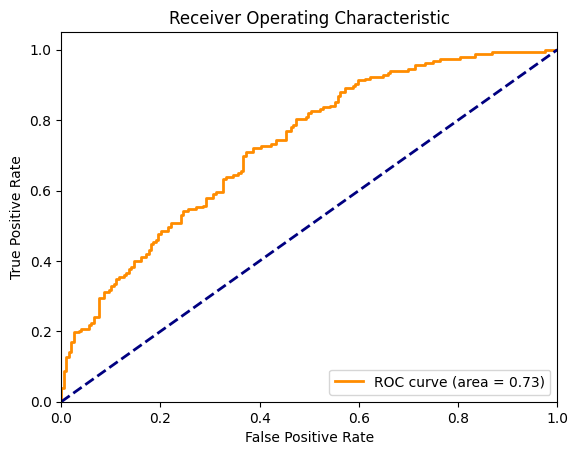

In [13]:
# Predict probabilities for the test set
y_test_proba = prediction_probabilities[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()